In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter

# Data Loading

In [2]:
# Download Dataset dari Google Drive
file_id = '1-y6XXsoTLwaqOevLGh7DCxZGbTyaSBwO'
url = f'https://drive.google.com/uc?id={file_id}'
dataset = 'dataset_mofe.csv'
gdown.download(url, dataset, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-y6XXsoTLwaqOevLGh7DCxZGbTyaSBwO
To: /content/dataset_mofe.csv
100%|██████████| 158k/158k [00:00<00:00, 26.2MB/s]


'dataset_mofe.csv'

Dataset yang digunakan dalam proyek ini merupakan hasil web scraping dari situs [mofe.co.id](https://mofe.co.id), yang merupakan platform penjualan motor bekas di Indonesia. Dataset difokuskan hanya pada motor bekas merk Honda, karena merupakan merk yang paling dominan dan tersedia dalam jumlah yang cukup besar di situs tersebut

In [3]:
# Load Data
df = pd.read_csv(dataset)

# Data Understanding

In [4]:
df

,Harga,Merk & Model,Tahun,Tipe / Varian,Jenis Transmisi,Warna,Jarak Tempuh,STNK,BPKB,Buku Servis
0,Rp 25.200.000,"Honda, ADV150",2019,CBS,Matic,Hitam,101.627 KM,Tersedia,Tersedia,Tersedia
1,Rp 21.800.000,"Honda, Vario125",2023,CBS,Matic,Hitam,11.000 KM,Tersedia,Tersedia,Tidak Tersedia
2,Rp 16.200.000,"Honda, SupraGTR150",2023,NaN,Cub,Hitam,97.172 KM,Tersedia,Tersedia,Tersedia
3,Rp 14.300.000,"Honda, BeATStreet",2023,NaN,Matic,Hitam,38.327 KM,Tersedia,Tersedia,Tersedia
4,Rp 26.900.000,"Honda, PCX160",2021,ABS,Matic,Merah,21.000 KM,Tersedia,Tersedia,Tidak Tersedia
...,...,...,...,...,...,...,...,...,...,...
1631,Rp 9.800.000,"Honda, BeAT",2015,CBS,Matic,Hitam,50.000 KM,Tersedia,Tersedia,Tidak Tersedia
1632,Rp 15.800.000,"Honda, BeAT",2023,(Deluxe) CBS-ISS,Matic,Biru,19.000 KM,Tersedia,Tersedia,Tidak Tersedia
1633,Rp 12.900.000,"Honda, BeAT",2019,CBS,Matic,Hitam,49.000 KM,Tersedia,Tersedia,Tidak Tersedia
1634,Rp 12.900.000,"Honda, BeAT",2019,CBS,Matic,Hitam,49.000 KM,Tersedia,Tersedia,Tidak Tersedia


Dari tampilan data ditemukan informasi
- Jumlah data 1636
- Jumlah kolom 10

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Harga            1636 non-null   object
 1   Merk & Model     1636 non-null   object
 2   Tahun            1636 non-null   int64 
 3   Tipe / Varian    1238 non-null   object
 4   Jenis Transmisi  1636 non-null   object
 5   Warna            1636 non-null   object
 6   Jarak Tempuh     1636 non-null   object
 7   STNK             1636 non-null   object
 8   BPKB             1636 non-null   object
 9   Buku Servis      1636 non-null   object
dtypes: int64(1), object(9)
memory usage: 127.9+ KB


Terlihat dari informasi jumlah baris di setiap kolom bahwa hanya kolom **Tipe / Varian** yang memiliki missing value, yaitu sebanyak **398 baris kosong** dari total 1.636. Sementara itu, 9 kolom lainnya tidak memiliki value yang hilang.

Selain itu, terdapat **9 fitur bertipe kategorikal** (bertipe `object`), seperti `Harga`, `Merk & Model`, `Tipe / Varian`, `Jenis Transmisi`, `Warna`, `Jarak Tempuh`, `STNK`, `BPKB`, dan `Buku Servis`.

Hanya kolom **Tahun** yang bertipe numerik (`int64`), menunjukkan bahwa sebagian besar fitur masih perlu diubah ke bentuk numerik agar dapat digunakan dalam pemodelan regresi.

Dengan **Harga** sebagai target fitur.

In [6]:
df.isnull().sum()

,0
Harga,0
Merk & Model,0
Tahun,0
Tipe / Varian,398
Jenis Transmisi,0
Warna,0
Jarak Tempuh,0
STNK,0
BPKB,0
Buku Servis,0


Terlihat bahwa hanya kolom **Tipe / Varian** yang memiliki nilai kosong sebanyak 398 baris. Sementara kolom lainnya tidak memiliki missing value sehingga siap digunakan dalam proses modeling.

# Data Cleaning

In [7]:
df_clean = df.copy()

# Bersihkan kolom Harga dan Jarak Tempuh
df_clean['Harga'] = df_clean['Harga'].str.replace('Rp', '', regex=False)
df_clean['Harga'] = df_clean['Harga'].str.replace('.', '', regex=False).str.strip().astype(int)
df_clean['Jarak Tempuh'] = df_clean['Jarak Tempuh'].str.replace('KM', '', regex=False)
df_clean['Jarak Tempuh'] = df_clean['Jarak Tempuh'].str.replace('.', '', regex=False).str.strip().astype(int)

# Bersihkan Merk & Model
df_clean['Merk & Model'] = df_clean['Merk & Model'].str.replace('Honda,', '', regex=False).str.strip()

# Isi nilai kosong pada Tipe / Varian
df_clean['Tipe / Varian'] = df_clean.groupby('Merk & Model')['Tipe / Varian']\
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'NaN'))

df_clean.isnull().sum()

,0
Harga,0
Merk & Model,0
Tahun,0
Tipe / Varian,0
Jenis Transmisi,0
Warna,0
Jarak Tempuh,0
STNK,0
BPKB,0
Buku Servis,0


Dilakukan proses pembersihan dan penanganan missing value pada data:

- **Harga**: Data awal berupa string seperti `'Rp 18.000.000'`. Dibersihkan dengan menghapus `'Rp'` dan titik (`.`), lalu dikonversi ke tipe `int`.
- **Jarak Tempuh**: Data seperti `'25.000 KM'` dibersihkan dari `'KM'` dan titik (`.`), lalu dikonversi ke tipe `int`.
- **Merk & Model**: String `'Honda, BeAT'` diubah menjadi `'BeAT'` untuk menyederhanakan label.
- **Tipe / Varian**: Terdapat 398 nilai kosong. Diisi menggunakan modus (nilai terbanyak) berdasarkan grup `Merk & Model`. Jika tidak ada modus, diisi dengan `'NaN'`.

Setelah pembersihan, seluruh kolom tidak lagi memiliki nilai kosong dan siap digunakan pada tahap analisis dan modeling.

# Univariate Analysis

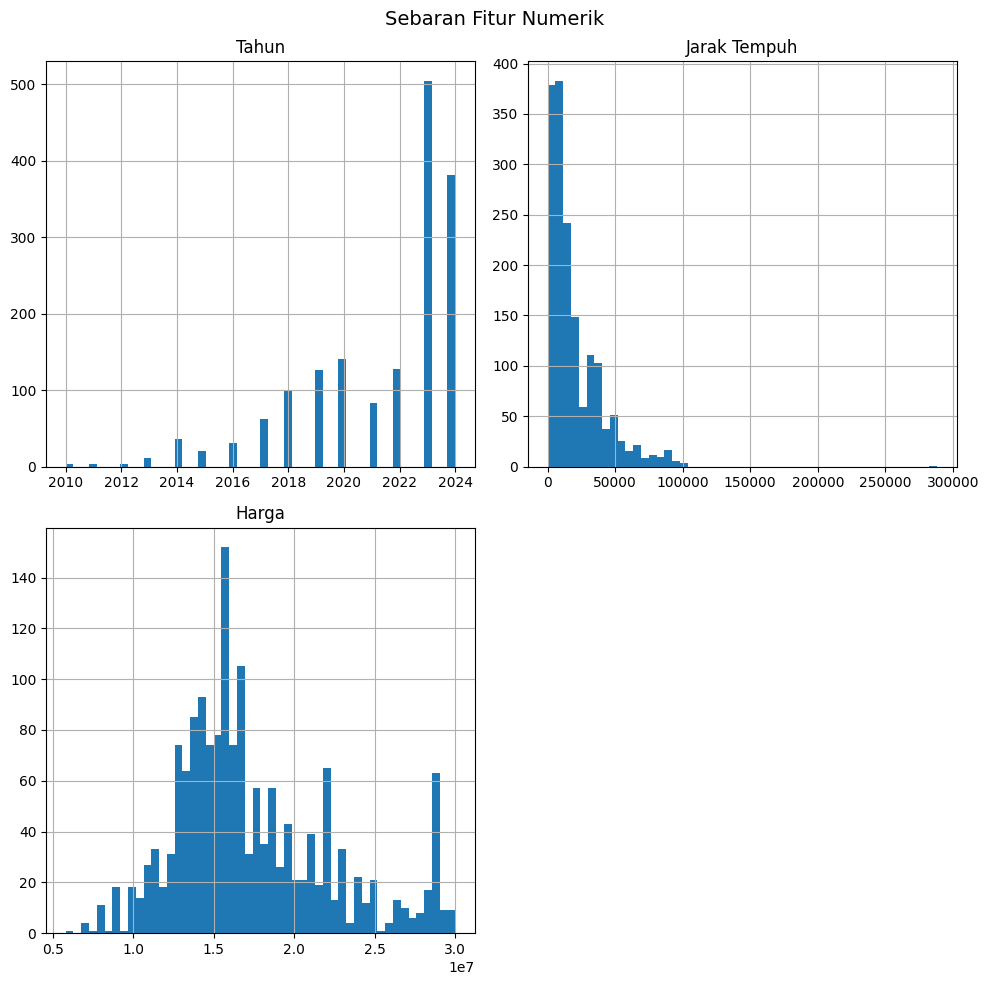

In [8]:
numeric_features = ['Tahun', 'Jarak Tempuh', 'Harga']
df_clean[numeric_features].hist(bins=50, figsize=(10, 10))
plt.suptitle('Sebaran Fitur Numerik', fontsize=14)
plt.tight_layout()
plt.show()

Visualisasi di atas menunjukkan histogram dari tiga fitur utama: **Tahun**, **Jarak Tempuh**, dan **Harga**.

- **Tahun**: Sebagian besar motor bekas dalam dataset diproduksi antara tahun 2021 hingga 2024. Hal ini mencerminkan bahwa motor yang dijual tergolong baru atau usia muda, yang berpengaruh pada harga pasar.

- **Jarak Tempuh**: Distribusi jarak tempuh menunjukkan bahwa mayoritas motor memiliki jarak tempuh di bawah 50.000 KM. Nilainya sangat bervariasi namun condong ke arah nilai rendah (right-skewed), dengan beberapa outlier di atas 100.000 KM.

- **Harga**: Sebaran harga motor bekas berkisar antara Rp10 juta hingga Rp30 juta, dengan puncak distribusi di sekitar Rp15–18 juta. Pola distribusi menunjukkan skew ke kanan, yang mengindikasikan bahwa sebagian besar motor berada di rentang harga menengah ke bawah.

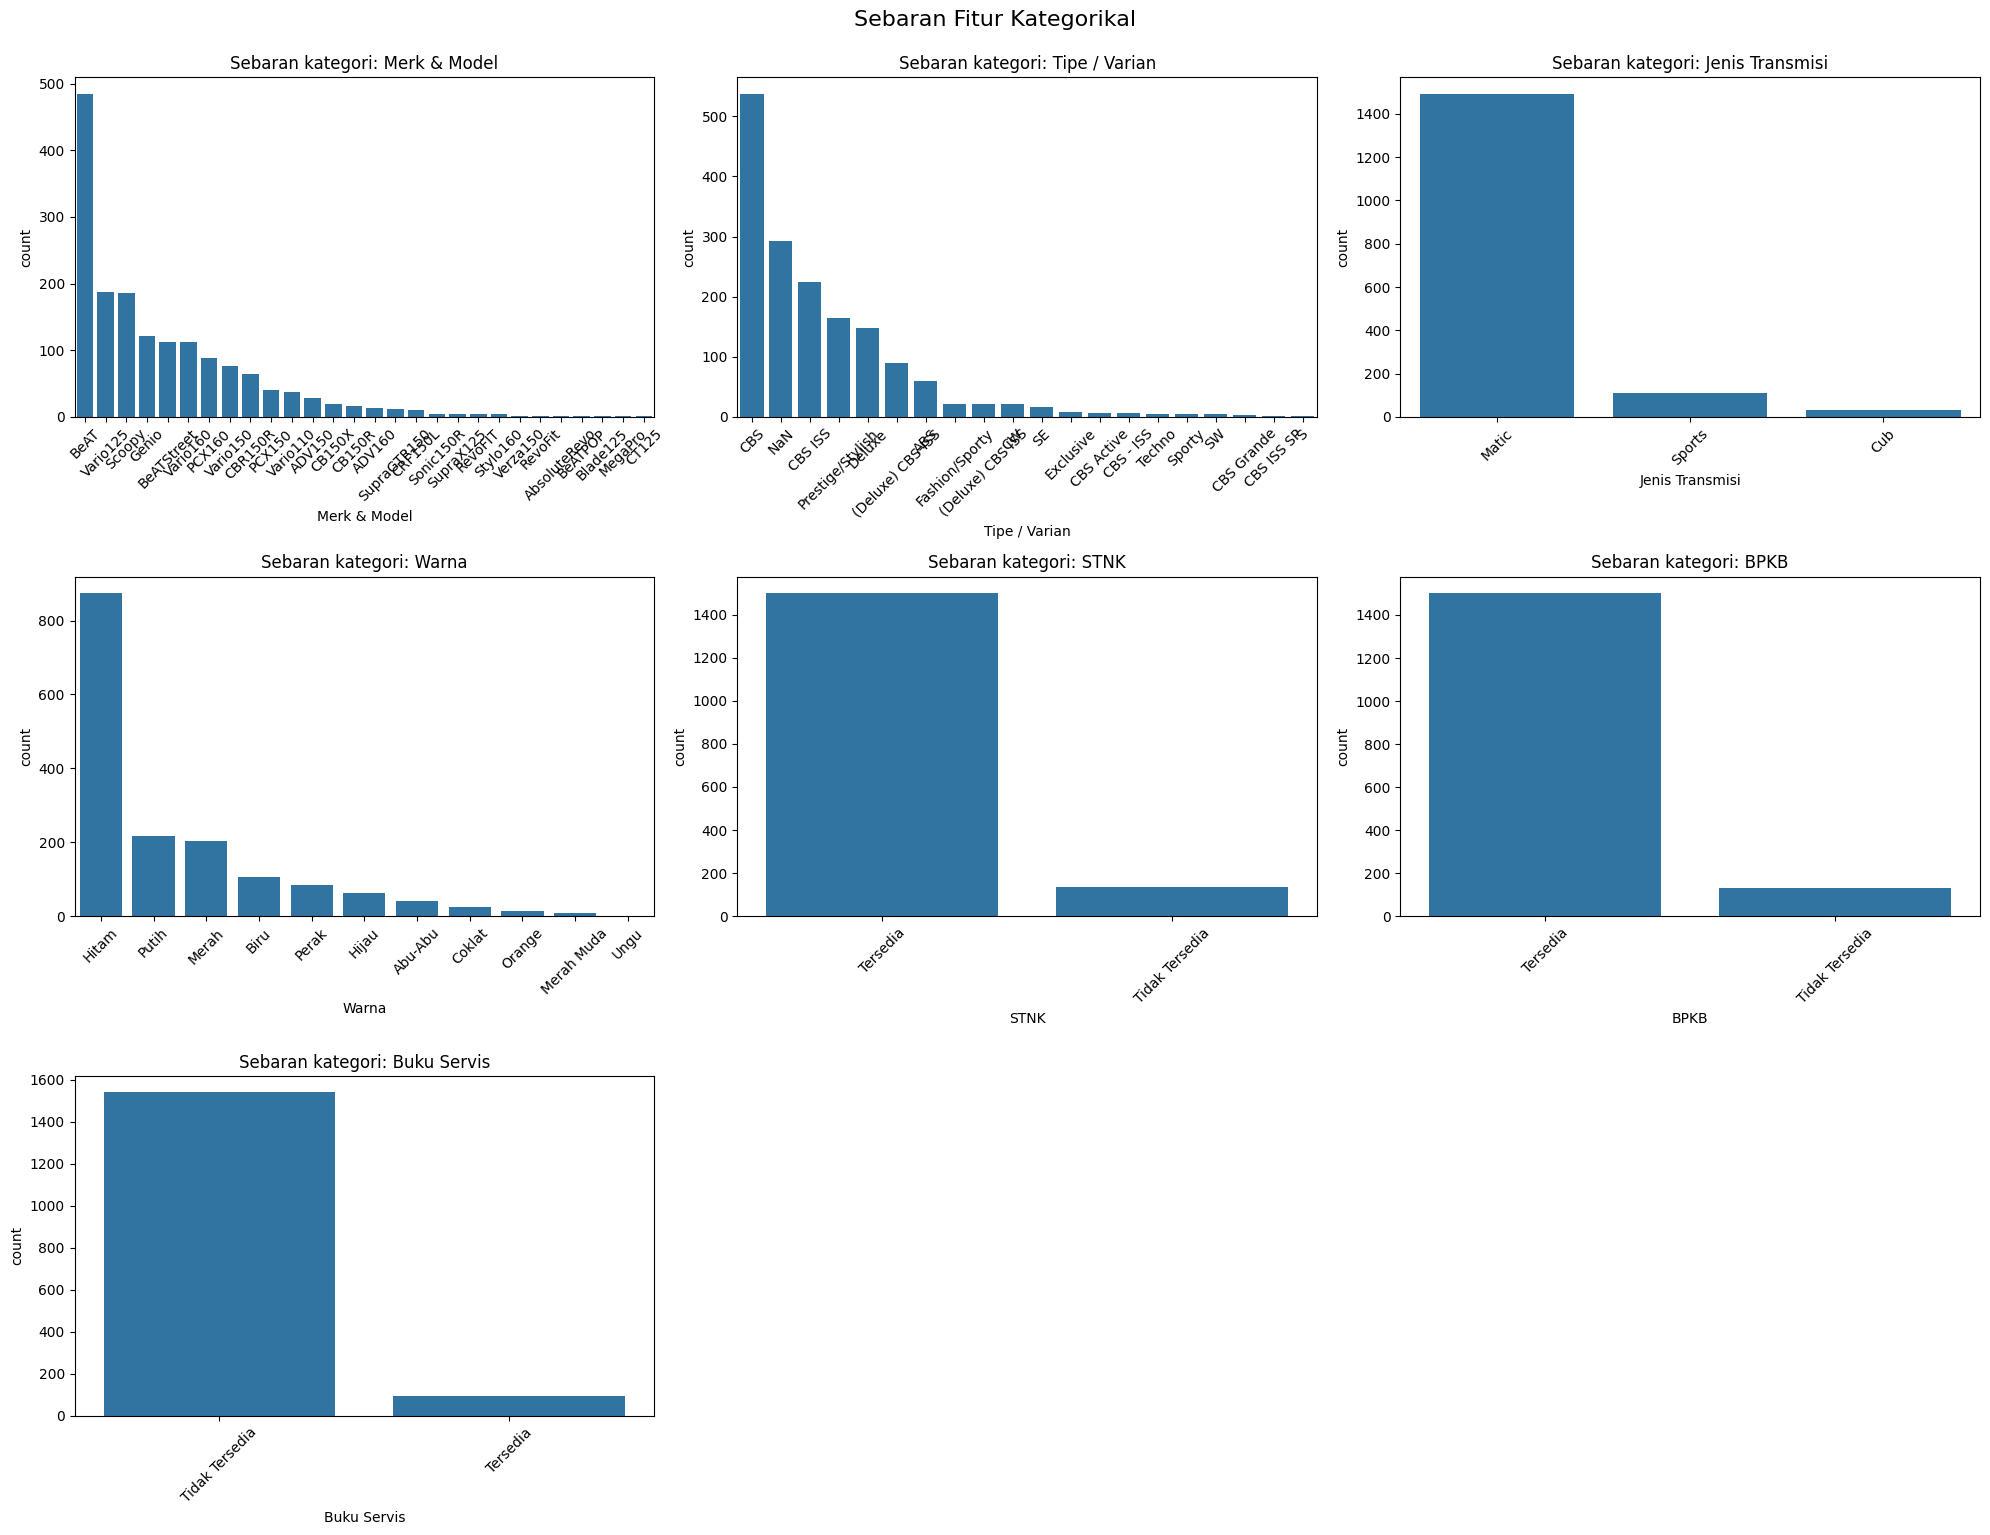

In [9]:
categorical_features = ['Merk & Model', 'Tipe / Varian', 'Jenis Transmisi', 'Warna', 'STNK', 'BPKB', 'Buku Servis']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=df_clean, x=feature, order=df_clean[feature].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Sebaran kategori: {feature}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Sebaran Fitur Kategorikal', fontsize=16, y=1.02)
plt.show()

Visualisasi menunjukkan histogram (jumlah kategori) untuk seluruh fitur kategorikal.

- **Merk & Model**: Model **BeAT** mendominasi dengan lebih dari 450 unit. Model lainnya seperti **Vario 125**, **Scoopy**, dan **Genio** juga cukup signifikan. Distribusi model sangat timpang, menunjukkan dominasi beberapa model populer.

- **Tipe / Varian**: Tipe **CBS** mendominasi, diikuti oleh **ISS**, **CBS ISS**, dan varian kombinasi lainnya. Sebagian besar data terfokus pada 3–5 varian utama, sementara sisanya hanya muncul dalam jumlah kecil.

- **Jenis Transmisi**: Mayoritas motor memiliki **transmisi matic**, menunjukkan bahwa matic adalah pilihan utama konsumen. Transmisi **sport** dan **cub** hanya sedikit.

- **Warna**: Warna **Hitam**, **Putih**, dan **Merah** paling umum. Warna seperti **Coklat**, **Ungu**, dan **Orange** jauh lebih jarang ditemukan, yang bisa mengindikasikan permintaan lebih rendah atau ketersediaan yang langka.

- **STNK** dan **BPKB**: Kedua dokumen ini **tersedia pada hampir seluruh motor**, yang penting untuk legalitas dan nilai jual kembali. Unit tanpa STNK atau BPKB sangat sedikit.

- **Buku Servis**: Uniknya, mayoritas motor **tidak memiliki buku servis**, yang mungkin disebabkan oleh kelalaian dalam pencatatan atau kurangnya perhatian pada histori perawatan oleh pemilik sebelumnya.

# Multivariate Analysis

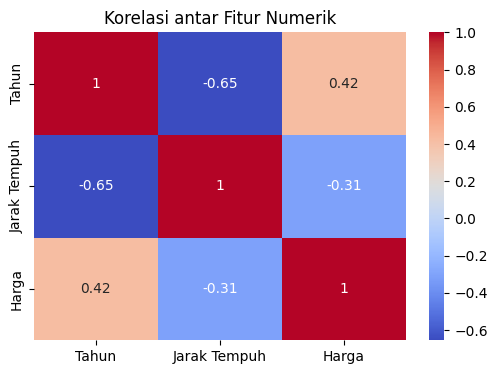

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_clean[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Fitur Numerik')
plt.show()

Berdasarkan heatmap diatas, dapat dilihat:

- **Tahun dan Jarak Tempuh** memiliki korelasi negatif yang kuat (**-0.65**), artinya motor yang lebih tua cenderung memiliki jarak tempuh lebih tinggi.
- **Jarak Tempuh dan Harga** memiliki korelasi negatif (**-0.31**), menunjukkan bahwa semakin besar jarak tempuh, harga cenderung turun.
- **Tahun dan Harga** memiliki korelasi positif (**0.42**), yang artinya motor lebih baru cenderung dihargai lebih mahal.

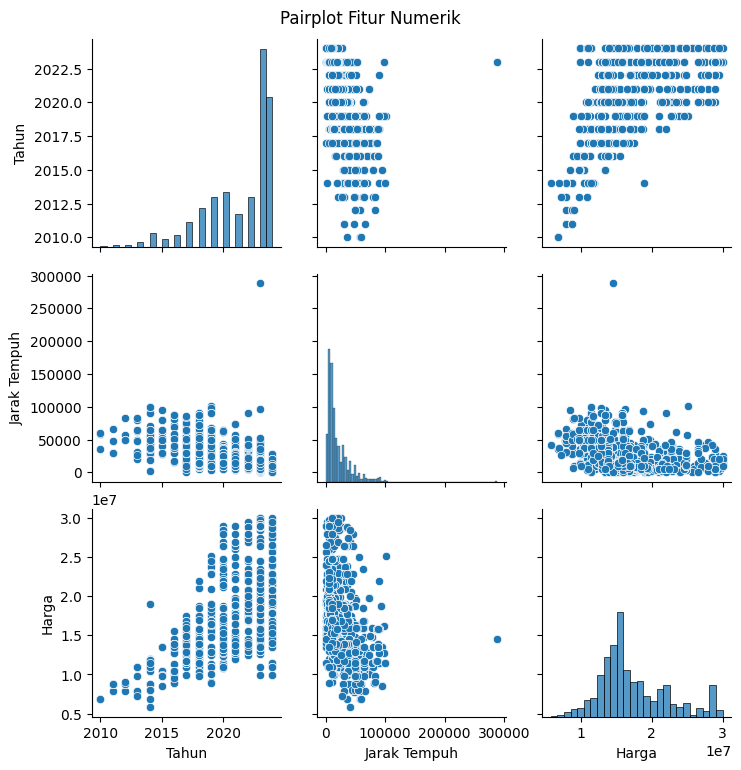

In [11]:
sns.pairplot(df_clean[numeric_features])
plt.suptitle('Pairplot Fitur Numerik', y=1.02)
plt.show()

Pairplot pada visualisasi di atas memperlihatkan hubungan visual antara fitur numerik:

- **Tahun vs Harga**: Terlihat pola korelasi positif yang cukup jelas — semakin baru tahunnya, semakin tinggi harga motor.
- **Jarak Tempuh vs Harga**: Terdapat korelasi negatif — motor dengan jarak tempuh rendah cenderung memiliki harga lebih tinggi.
- **Tahun vs Jarak Tempuh**: Pola sebaran menunjukkan bahwa motor keluaran lama memiliki jarak tempuh lebih tinggi, mendukung hasil korelasi sebelumnya.

Visualisasi ini memperkuat insight numerik bahwa `Tahun` dan `Jarak Tempuh` berperan penting dalam menentukan `Harga`, dan dapat dijadikan sebagai fitur utama dalam proses pemodelan.

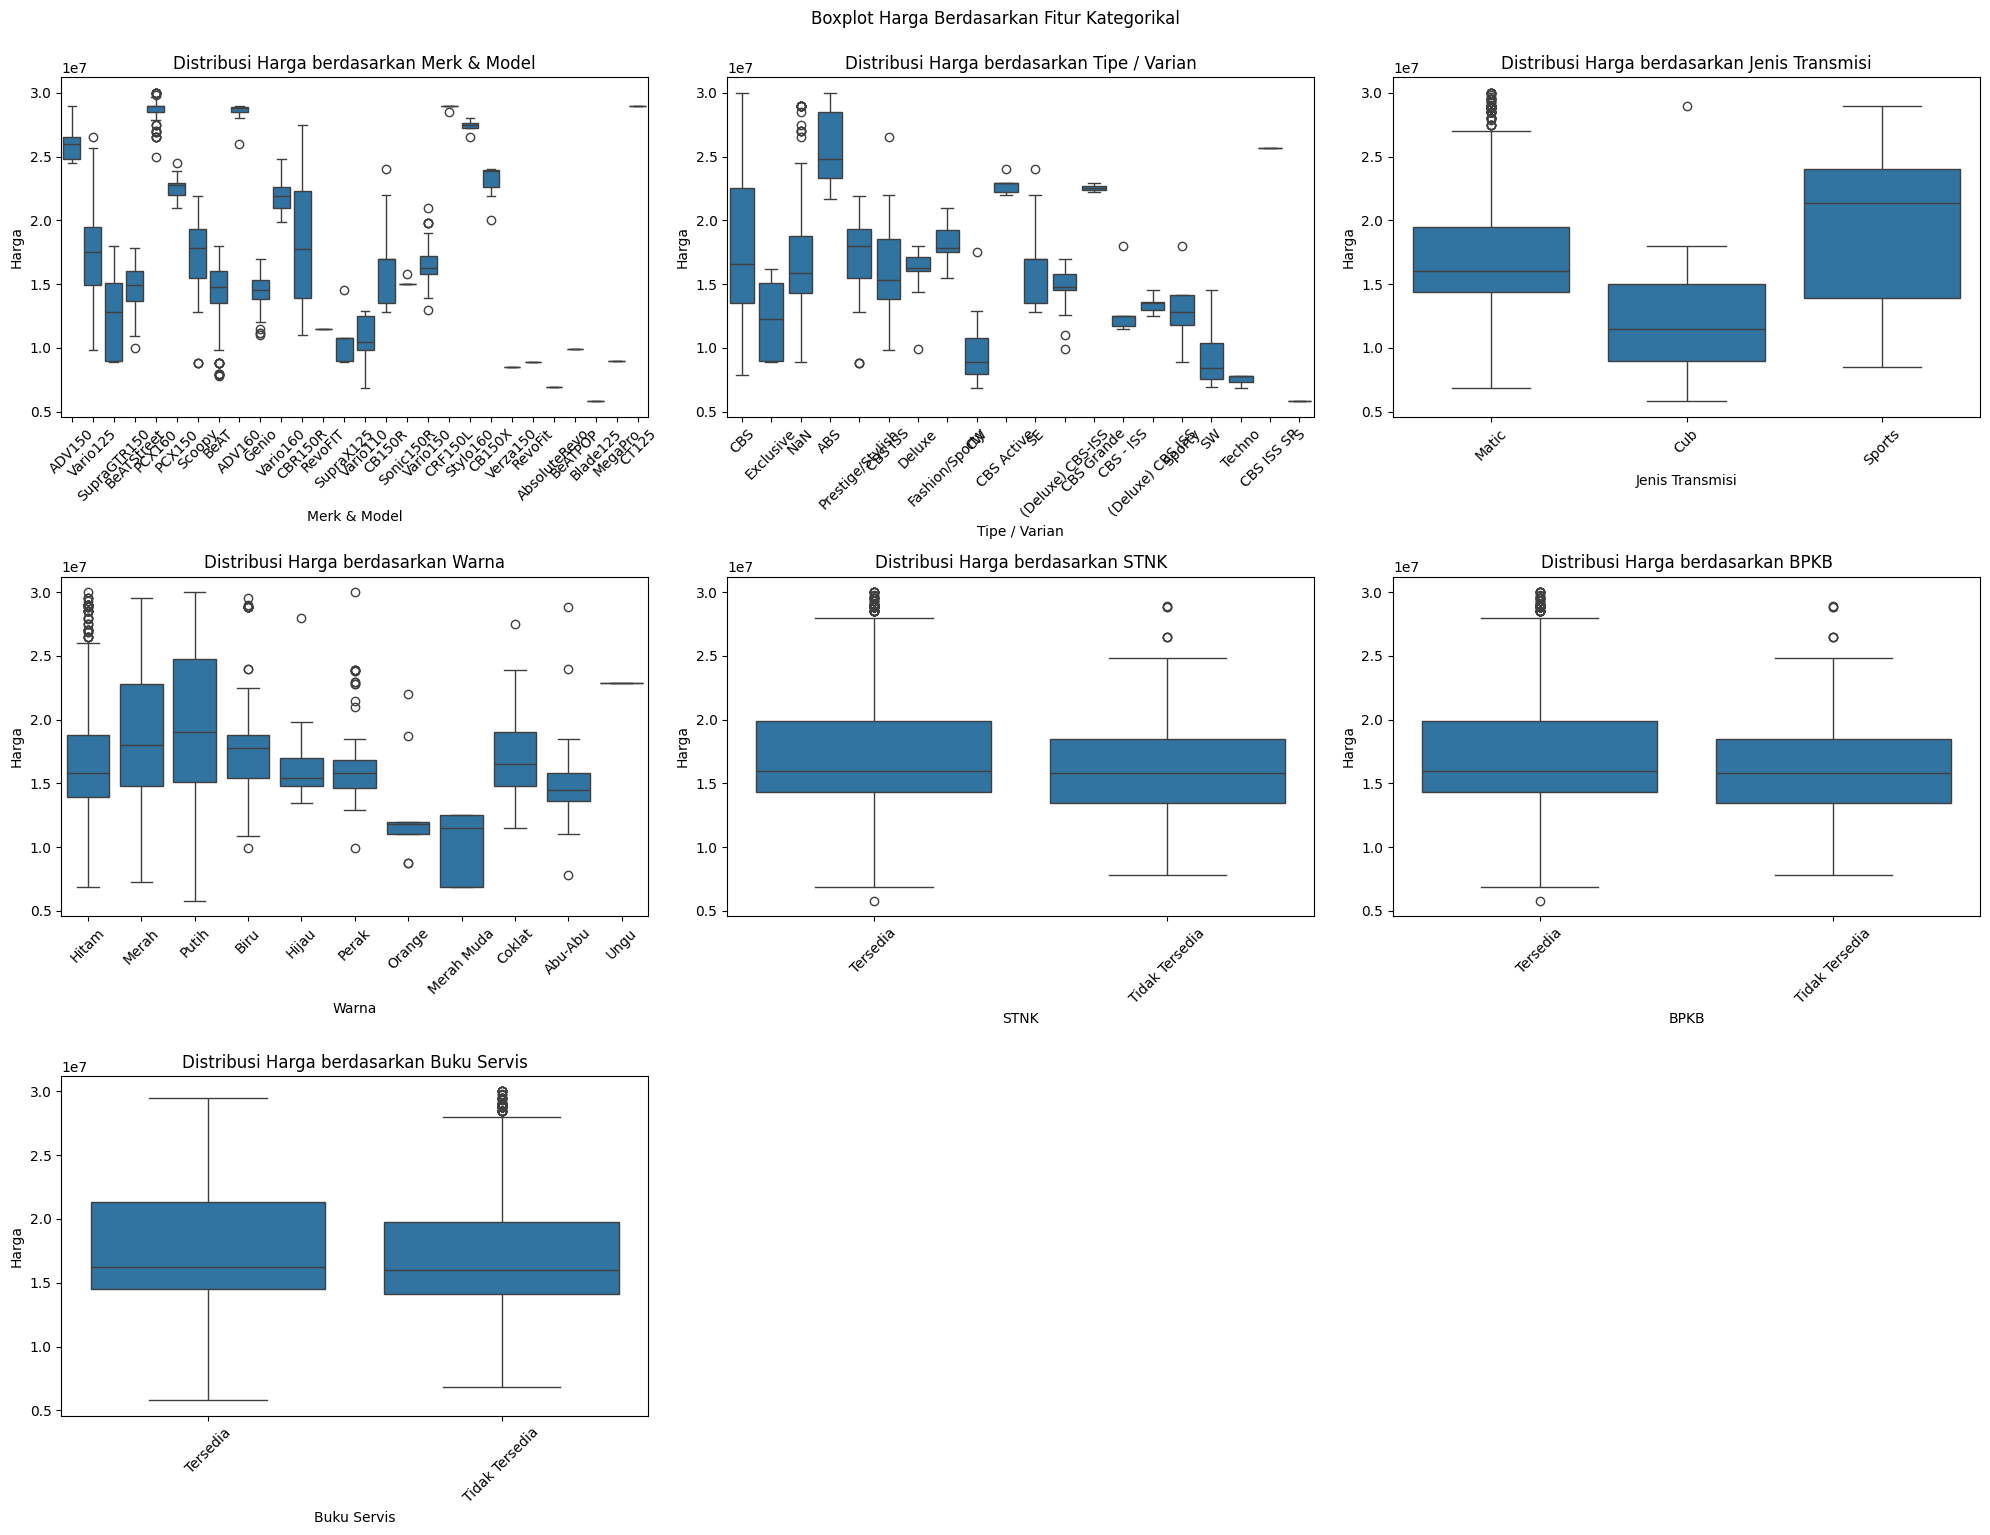

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.boxplot(data=df_clean, x=col, y='Harga', ax=axes[i])
    axes[i].set_title(f'Distribusi Harga berdasarkan {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplot Harga Berdasarkan Fitur Kategorikal', fontsize=12, y=1.02)
plt.show()

Visualisasi diatas menunjukkan hubungan antara harga dan beberapa fitur kategorikal:

- **Merk & Model**: Model seperti **ADV150**, **PCX160**, dan **CB150R** memiliki median harga lebih tinggi dibanding model seperti **Revo** atau **Blade125**. Hal ini menunjukkan bahwa tipe motor merupakan faktor signifikan dalam penentuan harga.

- **Tipe / Varian**: Varian **ABS**, **CBS ISS**, dan **ISS** cenderung dihargai lebih tinggi karena fitur tambahan yang ditawarkan.

- **Jenis Transmisi**: Motor **Sport** dan **Matic** menunjukkan median harga lebih tinggi dibanding **Cub**, yang biasanya lebih ekonomis.

- **Warna**: Warna seperti **Hijau**, **Merah**, dan **Hitam** memiliki persebaran harga lebih tinggi, meskipun pengaruh warna terhadap harga secara umum tidak terlalu signifikan.

- **STNK dan BPKB**: Motor dengan **STNK** dan **BPKB tersedia** menunjukkan median harga lebih tinggi. Kelengkapan dokumen secara langsung meningkatkan nilai jual motor.

- **Buku Servis**: Motor dengan **buku servis tersedia** sedikit lebih tinggi secara median, meskipun tidak sebesar pengaruh STNK/BPKB. Hal ini menunjukkan bahwa histori servis tidak menjadi faktor utama, tetapi tetap menambah nilai kepercayaan pembeli.

# Data Preparation

In [13]:
# Data Preparation
model_df = df_clean.copy()
features = ['Tahun', 'Jarak Tempuh', 'Merk & Model', 'Tipe / Varian',
            'Jenis Transmisi', 'Warna', 'STNK', 'BPKB', 'Buku Servis']
target = 'Harga'

# Encoding
categorical_cols = model_df[features].select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    encoders[col] = le

Fitur-fitur kategorikal tidak bisa langsung digunakan dalam model numerik. Oleh karena itu, dilakukan proses encoding menggunakan `LabelEncoder` dari scikit-learn

In [14]:
# Split Data
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan jumlah sampel
print(f'Total jumlah sampel: {len(X)}')
print(f'Jumlah data latih  : {len(X_train)}')
print(f'Jumlah data uji    : {len(X_test)}')

Total jumlah sampel: 1636
Jumlah data latih  : 1308
Jumlah data uji    : 328


Dataset dibagi menjadi data latih dan data uji dengan rasio 80:20 menggunakan `train_test_split`.

- **Total sampel**: 1.636
- **Data latih**: 1.308 (80%)
- **Data uji**: 328 (20%)

# Model Training & Evaluation

In [15]:
# Inisialisasi model
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)

# Latih model
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Prediksi
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

Model yang digunakan adalah Random Forest, Gradient Boosting, Decision Tree.

In [16]:
# Evaluasi fungsi
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"MAE      : {int(mae):,}".replace(",", "."))
    print(f"MSE      : {int(mse):,}".replace(",", "."))
    print(f"RMSE     : {int(rmse):,}".replace(",", "."))
    print(f"R-Squared: {r2:.4f}")

# Evaluasi semua model
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Gradient Boosting", y_test, gb_pred)
evaluate_model("Decision Tree", y_test, dt_pred)


Random Forest
-------------
MAE      : 572.891
MSE      : 972.862.376.379
RMSE     : 986.337
R-Squared: 0.9565

Gradient Boosting
-----------------
MAE      : 823.975
MSE      : 1.178.773.925.849
RMSE     : 1.085.713
R-Squared: 0.9473

Decision Tree
-------------
MAE      : 615.243
MSE      : 1.613.999.077.291
RMSE     : 1.270.432
R-Squared: 0.9278


Evaluasi awal terhadap tiga model: **Random Forest**, **Gradient Boosting**, dan **Decision Tree** menggunakan metrik MAE, MSE, RMSE, dan R².

# Model Tuning (GridSearchCV)

In [17]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params,
                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.01]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params,
                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

# Decision Tree
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params,
                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

Untuk meningkatkan performa model, dilakukan proses **hyperparameter tuning** menggunakan **GridSearchCV** pada ketiga model:

- **Random Forest**: Dicari kombinasi terbaik dari `n_estimators`, `max_depth`, dan `min_samples_split`.
- **Gradient Boosting**: Dicoba beberapa kombinasi `n_estimators`, `max_depth`, dan `learning_rate`.
- **Decision Tree**: Dilakukan tuning pada `max_depth` dan `min_samples_split`.

Proses tuning menggunakan validasi silang sebanyak **3 fold** dan metrik evaluasi berupa **negative MAE**. Hasil terbaik dari setiap model disimpan sebagai estimator akhir (`best_rf`, `best_gb`, dan `best_dt`) untuk digunakan pada tahap prediksi dan evaluasi berikutnya.

In [18]:
# Prediksi Tuned
best_rf_pred = best_rf.predict(X_test)
best_gb_pred = best_gb.predict(X_test)
best_dt_pred = best_dt.predict(X_test)

# Evaluasi Tuned
evaluate_model("Random Forest (Tuned)", y_test, best_rf_pred)
evaluate_model("Gradient Boosting (Tuned)", y_test, best_gb_pred)
evaluate_model("Decision Tree (Tuned)", y_test, best_dt_pred)

print("Best Random Forest Params      :", rf_grid.best_params_)
print("Best Gradient Boosting Params  :", gb_grid.best_params_)
print("Best Decision Tree Params      :", dt_grid.best_params_)


Random Forest (Tuned)
---------------------
MAE      : 568.904
MSE      : 971.402.622.758
RMSE     : 985.597
R-Squared: 0.9566

Gradient Boosting (Tuned)
-------------------------
MAE      : 552.314
MSE      : 1.099.064.996.809
RMSE     : 1.048.363
R-Squared: 0.9509

Decision Tree (Tuned)
---------------------
MAE      : 616.081
MSE      : 1.629.164.854.730
RMSE     : 1.276.387
R-Squared: 0.9272
Best Random Forest Params      : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Gradient Boosting Params  : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best Decision Tree Params      : {'max_depth': 20, 'min_samples_split': 2}


**Random Forest (Tuned)**
- MAE: 568.9, RMSE: 985.6, R²: 0.9566 (terbaik)
- Parameter: `max_depth=None`, `min_samples_split=2`, `n_estimators=200`
- Model paling akurat, mampu jelaskan 95.66% variasi data.

**Gradient Boosting (Tuned)**
- MAE: 552.3, RMSE: 1,048.4, R²: 0.9509
- Parameter: `learning_rate=0.1`, `max_depth=10`, `n_estimators=200`
- Performa bagus, sedikit di bawah Random Forest.

**Decision Tree (Tuned)**
- MAE: 616.1, RMSE: 1,276.4, R²: 0.9272 (paling rendah)
- Parameter: `max_depth=20`, `min_samples_split=2`
- Mengalami sedikit penurunan akurasi, rentan overfitting.

**Kesimpulan**

Random Forest terbaik untuk prediksi harga motor bekas dengan performa paling stabil dan akurat.

In [19]:
# Perbandingan MAE dan R2 Sebelum vs Sesudah Tuning
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'GradientBoosting', 'Decision Tree'],
    'MAE Default': [
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, gb_pred),
        mean_absolute_error(y_test, dt_pred)
    ],
    'MAE Tuned': [
        mean_absolute_error(y_test, best_rf_pred),
        mean_absolute_error(y_test, best_gb_pred),
        mean_absolute_error(y_test, best_dt_pred)
    ],
    'R2 Default': [
        r2_score(y_test, rf_pred),
        r2_score(y_test, gb_pred),
        r2_score(y_test, dt_pred)
    ],
    'R2 Tuned': [
        r2_score(y_test, best_rf_pred),
        r2_score(y_test, best_gb_pred),
        r2_score(y_test, best_dt_pred)
    ],
})

model_comparison[['MAE Default', 'MAE Tuned']] = model_comparison[
    ['MAE Default', 'MAE Tuned']
].applymap(lambda x: f"{int(x):,}".replace(",", "."))

model_comparison

<ipython-input-19-85c1e3cd13b6>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: f"{int(x):,}".replace(",", "."))


,Model,MAE Default,MAE Tuned,R2 Default,R2 Tuned
0,Random Forest,572.891,568.904,0.956503,0.956568
1,GradientBoosting,823.975,552.314,0.947297,0.950860
2,Decision Tree,615.243,616.081,0.927837,0.927159


- **Random Forest**: Tuning memberikan perbaikan kecil tapi konsisten pada MAE dan R².
- **Gradient Boosting**: Tuning memberikan peningkatan signifikan pada MAE dan sedikit peningkatan pada R².
- **Decision Tree**: Tuning tidak banyak memperbaiki MAE dan sedikit menurunkan R², performa hampir sama.

In [20]:
# Perbandingan MSE Train dan Test
mse_df = pd.DataFrame(columns=['Train MSE', 'Test MSE'],
                      index=['Random Forest', 'GradientBoosting', 'Decision Tree'])

model_dict = {
    'Random Forest': best_rf,
    'GradientBoosting': best_gb,
    'Decision Tree': best_dt
}

for name, model in model_dict.items():
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    mse_df.loc[name] = [train_mse, test_mse]

mse_df

,Train MSE,Test MSE
Random Forest,233624370412.206818,971402622758.955444
GradientBoosting,107683781686.095993,1099064996809.963013
Decision Tree,108235621030.34581,1629164854730.031738


- **Random Forest** menunjukkan kenaikan MSE dari train ke test yang cukup besar, namun tetap memberikan generalisasi terbaik dibandingkan model lain.
- **Gradient Boosting** memiliki MSE test lebih tinggi dari train, menandakan model mulai overfit namun performa masih cukup baik.
- **Decision Tree** memiliki gap MSE train vs test paling besar, indikasi overfitting yang cukup parah.

Random Forest tetap paling stabil dan unggul dalam generalisasi dibanding Gradient Boosting dan Decision Tree.

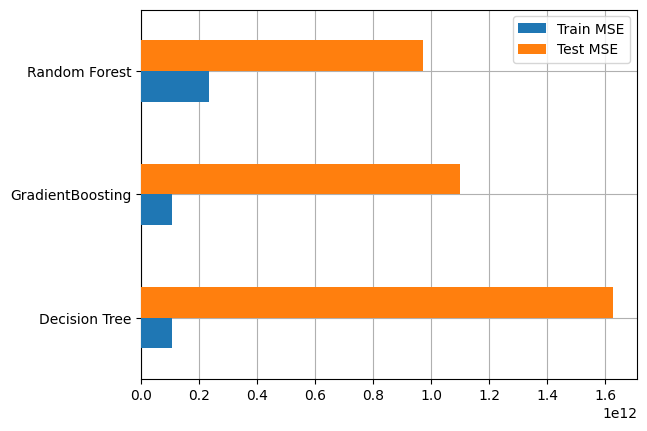

In [21]:
fig, ax = plt.subplots()
mse_df.sort_values(by='Test MSE', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Grafik di atas menampilkan perbandingan antara **Train MSE** dan **Test MSE** untuk masing-masing model:

- **Random Forest** memiliki selisih MSE yang besar antara data train dan test, namun tetap menunjukkan generalisasi yang lebih baik dibandingkan model lainnya.
- **Gradient Boosting** juga menunjukkan peningkatan MSE pada data test, tetapi performanya masih cukup stabil.
- **Decision Tree** menunjukkan MSE test paling tinggi, menandakan adanya **overfitting** yang signifikan terhadap data latih.

In [22]:
# Prediksi Sample
prediksi = X_test.iloc[5:10].copy()
pred_dict = {'Harga Asli': y_test.iloc[5:10]}

for name, model in model_dict.items():
    pred_dict[name] = model.predict(prediksi).round(1)

hasil_prediksi = pd.DataFrame(pred_dict)

hasil_prediksi

,Harga Asli,Random Forest,GradientBoosting,Decision Tree
1033,8800000,8319500.0,8783464.5,8800000.0
1582,13000000,13491500.0,13081842.6,13800000.0
1309,24500000,24527000.0,24499978.8,24500000.0
1626,17000000,17085000.0,16999427.5,17000000.0
271,12700000,13659000.0,13675289.3,13600000.0


- Semua model menghasilkan prediksi yang cukup mendekati harga asli.
- **Decision Tree** cenderung memprediksi tepat pada nilai harga asli, kemungkinan karena model **overfit** terhadap data train.
- **Random Forest** dan **Gradient Boosting** sedikit meleset, namun menunjukkan generalisasi yang baik dan tidak terpaku pada data spesifik.

**Kesimpulan:**
Model ensemble memberikan prediksi yang konsisten dan realistis, sementara Decision Tree bisa terlalu mengikuti data latih, berisiko kurang akurat pada data baru.